In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

1. Gerekli kütüphaneler yüklendi. Aynı zamanda cifar10 isimli veri seti kütüphaneside yüklendi



170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


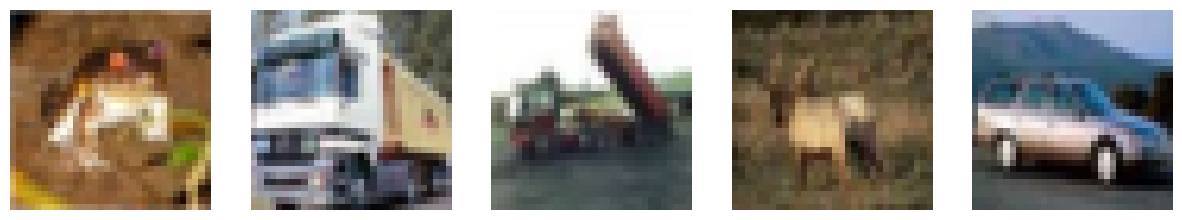

In [2]:
# CIFAR-10 veri seti
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Veriyi .npy formatında kaydedelim
os.makedirs("/content/data", exist_ok=True)  # data klasörü
np.save("/content/data/x_train.npy", x_train)
np.save("/content/data/y_train.npy", y_train)
np.save("/content/data/x_test.npy", x_test)
np.save("/content/data/y_test.npy", y_test)


x_train = np.load('/content/data/x_train.npy')
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # 5 adet görsel
for i, ax in enumerate(axes):
    ax.imshow(x_train[i])  # Görseli çizimi
    ax.axis('off')
plt.show()

2. Veri setini görebilmek için fiziksel olarak da indirdim. İçerik hakkında bilgi sahibi olabilmek için 5 tanesini görüntüledim.

In [3]:
# CIFAR-10 veri seti
x_train = np.load('/content/data/x_train.npy')
y_train = np.load('/content/data/y_train.npy')

# Veriyi %80 eğitim, %20 test olarak ayrılıyor
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42)

# Ayrım işlemi
print(f"Eğitim verisi boyutu: {x_train_split.shape}")
print(f"Test verisi boyutu: {x_test_split.shape}")

Eğitim verisi boyutu: (40000, 32, 32, 3)
Test verisi boyutu: (10000, 32, 32, 3)


3. Veri setindeki görseller %80 eğitim %20 test olarak ayrıldı. Verinin içeriği görüntülendi. Toplam 50 000 bin görsel varmış.Yükseklik ve genişlik 32px. Veri Setindeki görseller renkli(RGB).

In [4]:
# Eğitim ve test verisini tek bir vektöre çevriliyor. görsel pikselleri yan yana konuyor
x_train_flattened = x_train_split.reshape(x_train_split.shape[0], -1)  # (40000, 32*32*3)
x_test_flattened = x_test_split.reshape(x_test_split.shape[0], -1)
# Standartlaştırma
scaler = StandardScaler()
# Eğitim ve test verilerini fit ve transform yapılıyor
x_train_scaled = scaler.fit_transform(x_train_flattened)
x_test_scaled = scaler.transform(x_test_flattened)

print(f"Ölçeklenmiş eğitim verisi boyutu: {x_train_scaled.shape}")
print(f"Ölçeklenmiş test verisi boyutu: {x_test_scaled.shape}")

Ölçeklenmiş eğitim verisi boyutu: (40000, 3072)
Ölçeklenmiş test verisi boyutu: (10000, 3072)


4. Burada görseller tek satır haline getirildi. Daha sonra fit_transform fonksiyonu ile verinin genel ortalaması, genel standart sapması daha sonra bu verilere göre her bir pixel'e bu ortalama ve standart saplalar uygulanarak pixel değerleri 0 ile 1 değerleri arasına dönüştürüldü.

In [ ]:
from joblib import dump
# MLP modelini oluşturuyoruz
#mlp = MLPClassifier(max_iter=300, random_state=42)
#mlp = MLPClassifier(max_iter=200, random_state=42, verbose=True)
mlp = MLPClassifier(max_iter=200, solver='adam', random_state=42, early_stopping=True, n_iter_no_change=10)

# Parametrelerin deneneceği bir parametre ızgarası (grid) oluşturuyoruz
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (200,)],  # Daha küçük katman yapıları
    'activation': ['relu', 'tanh', 'logistic'],  # Karmaşık olmayan aktivasyon fonksiyonları
    'learning_rate': ['constant', 'adaptive'],  # Öğrenme oranı seçenekleri
    'learning_rate_init': [0.001, 0.01, 0.1]  # Daha az başlatma değerleri
}

# GridSearchCV kullanarak hiperparametre araması yapıyoruz
grid_search = GridSearchCV(mlp, param_grid, cv=3, n_jobs=-1, verbose=2)

# Eğitim verisi üzerinde modeli eğitiyoruz
grid_search.fit(x_train_scaled, y_train_split)

# En iyi parametreler ve model
best_model = grid_search.best_estimator_

# En iyi parametreler
print(f"En iyi parametreler: {grid_search.best_params_}")

# Test verisi üzerinde modelin doğruluğunu değerlendiriyoruz
y_pred = best_model.predict(x_test_scaled)
accuracy = accuracy_score(y_test_split, y_pred)
print(f"Test doğruluğu: {accuracy * 100:.2f}%")
# Modeli yerel bilgisayarınıza kaydetme
model_save_path = "mlp_best_model.joblib"
dump(best_model, model_save_path)
print(f"Model yerel bilgisayarınıza kaydedildi: {model_save_path}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


En iyi parametreler: {'activation': 'relu', 'hidden_layer_sizes': (200,), 'learning_rate': 'constant', 'learning_rate_init': 0.001}
Test doğruluğu: 49.37%
Model yerel bilgisayarınıza kaydedildi: mlp_best_model.joblib



1. Deneme Yüksek layer ve max_iter değerleri ile defalarca denemeler sonunda model eğitimi çok uzun süreler beklendi ve sonuç alınamadı bunun üzerine parametreler değiştirildi(düşürüldü).

----------------------------------------------------------

2. Deneme En iyi parametreler: {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.001}
Test doğruluğu: 43.60%

Model eğitimi tamamlandığında. En iyi parametleri ve Test doğruluk oranını %43 olarak verdi. Bunun üzerine parametrelerde düzenleme yapıyoruz.

-----------------------------------------------------------

3. Deneme İkinci eğitimde max_iter (Iterasyon Sayısı) değerini 100'den 200'e çıkartıyoruz. Learning_rate değerini sadece Adaptive olarak ayarlıyoruz ki her iterasyonda öğrenme oranını duruma göre değiştirsin.

**Yeni değerler şu şekilde;**

'hidden_layer_sizes': [(80,), (50, 50), (60, 60)],
'activation': ['relu', 'tanh'],  
'learning_rate': ['adaptive'],  
'learning_rate_init': [0.001, 0.01]

mlp = MLPClassifier(max_iter=200, solver='adam', random_state=42, early_stopping=True, n_iter_no_change=10)

Ayrıca ezberlemeyi önlemek için erken durdurma uygulandı. Optimizer olarak adam belirlendi. 10 kez öğrenmede değişiklik olmassa eğitimi durdurma parametresi eklendi. Ancak %49 doğruluk oranına ulaşılabildi.



In [ ]:
import joblib

# Eğitilmiş modeli yükleme
best_model = joblib.load('/content/mlp_best_model1.joblib')
# Modelin test verisi üzerinde tahmin yapması
y_pred = best_model.predict(x_test_scaled)

best_model2 = joblib.load('/content/mlp_best_model.pkl')
# Modelin test verisi üzerinde tahmin yapması
y_pred2 = best_model.predict(x_test_scaled)

# Doğruluk (accuracy) hesaplama
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_split, y_pred)

# Test doğruluğunu yazdırma
print(f"Test doğruluğu: {accuracy * 100:.2f}%")

Test doğruluğu: 9.75%


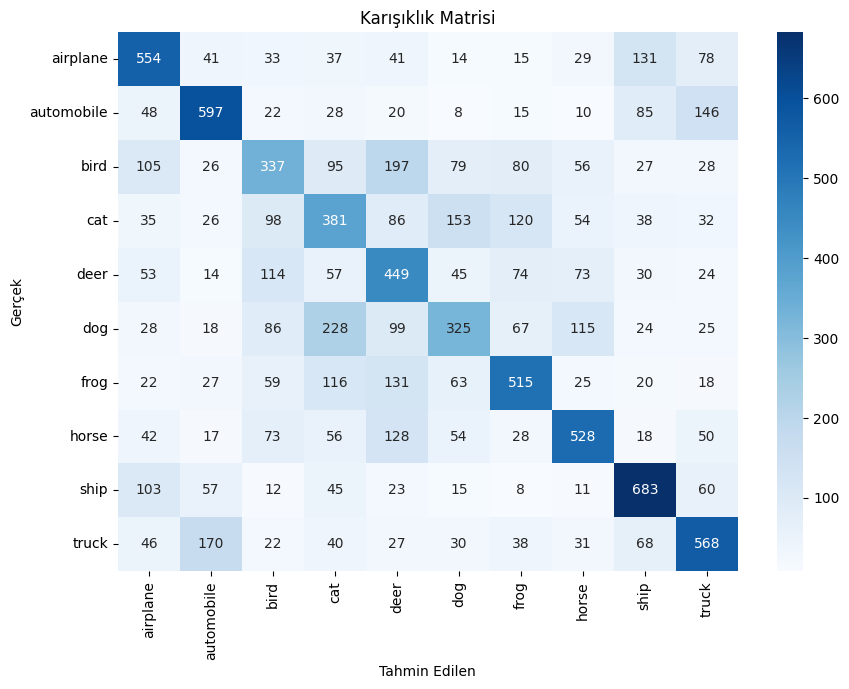

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# CIFAR10 veri seti örneği için sınıf isimleri:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Karışıklık matrisi
cm = confusion_matrix(y_test_split, y_pred)

# Karışıklık matrisini görselleştirme
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Karışıklık Matrisi")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Test verilerinin tahmini (y_pred)
y_pred = best_model.predict(x_test_scaled)  # En iyi model ile test verisinde tahmin


if len(y_pred.shape) > 1:  # Çoklu sınıf
    y_pred = np.argmax(y_pred, axis=1)

# Sınıflandırma raporunu oluştur
report = classification_report(y_test, y_pred, target_names=None)

# Raporu yazdır
print("Sınıflandırma Raporu:")
print(report)

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.10      0.10      0.10      1000
           1       0.10      0.10      0.10      1000
           2       0.09      0.08      0.08      1000
           3       0.10      0.10      0.10      1000
           4       0.11      0.14      0.12      1000
           5       0.09      0.07      0.08      1000
           6       0.10      0.10      0.10      1000
           7       0.10      0.09      0.09      1000
           8       0.10      0.12      0.11      1000
           9       0.11      0.11      0.11      1000

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.10     10000
weighted avg       0.10      0.10      0.10     10000



In [ ]:
# Gerekli kütüphanelerin yüklenmesi
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import numpy as np


# 1. Veri yeniden şekillendirme (4D → 2D)
num_train_samples = x_train.shape[0]
num_test_samples = x_test.shape[0]

x_train_reshaped = x_train.reshape(num_train_samples, -1)  # (num_samples, height * width * channels)
x_test_reshaped = x_test.reshape(num_test_samples, -1)    # (num_samples, height * width * channels)

# 2. Özellik ölçeklendirme
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_reshaped)
x_test_scaled = scaler.transform(x_test_reshaped)

# 3. Veri karıştırma (opsiyonel)
x_train_scaled, y_train = shuffle(x_train_scaled, y_train, random_state=42)

# 4. MLPClassifier için hiperparametre aralıkları
param_dist = {
    "hidden_layer_sizes": [(50, 50), (100, 100), (150, 100, 50), (200,)],  # Gizli katman yapılandırmaları
    "activation": ["relu", "tanh"],  # Aktivasyon fonksiyonları
    "solver": ["adam", "sgd"],  # Optimizasyon algoritmaları
    "alpha": [0.0001, 0.001, 0.01, 0.1],  # Düzenleme parametresi
    "learning_rate": ["constant", "adaptive"],  # Öğrenme hızı
    "learning_rate_init": [0.001, 0.01, 0.1],  # Başlangıç öğrenme oranı
    "max_iter": [200, 300, 500]  # Maksimum iterasyon
}

# 5. MLPClassifier modeli
mlp = MLPClassifier(random_state=42)

# 6. RandomizedSearchCV kullanımı
random_search = RandomizedSearchCV(
    mlp,
    param_distributions=param_dist,
    n_iter=20,  # Rastgele seçilecek kombinasyon sayısı
    scoring="accuracy",  # Değerlendirme metriği
    n_jobs=-1,  # Paralel işlem
    cv=3,  # 3-fold çapraz doğrulama
    verbose=2,
    random_state=42
)

# 7. Model eğitimi ve en iyi parametrelerin bulunması
print("RandomizedSearchCV başlatılıyor...")
random_search.fit(x_train_scaled, y_train)

# 8. En iyi parametreler
print("En iyi parametreler:")
print(random_search.best_params_)

# 9. En iyi modeli kaydetme
best_model = random_search.best_estimator_
model_path = "mlp_best_model.pkl"
joblib.dump(best_model, model_path)
print(f"En iyi model kaydedildi: {model_path}")

# 10. Kaydedilen modeli yükleme
loaded_model = joblib.load(model_path)
print("Kaydedilen model yüklendi.")

# 11. Yüklenen model ile test verisi üzerinde değerlendirme
y_pred = loaded_model.predict(x_test_scaled)

# 12. Sınıflandırma raporu
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

RandomizedSearchCV başlatılıyor...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
3 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 751, in fit
    return self._fit(X, y, incremental=False)
  File "/usr/local

En iyi parametreler:
{'solver': 'adam', 'max_iter': 200, 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (150, 100, 50), 'alpha': 0.001, 'activation': 'relu'}
En iyi model kaydedildi: mlp_best_model.pkl
Kaydedilen model yüklendi.

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.64      0.53      0.58      1000
           1       0.46      0.79      0.58      1000
           2       0.47      0.31      0.37      1000
           3       0.28      0.14      0.19      1000
           4       0.32      0.49      0.39      1000
           5       0.40      0.54      0.46      1000
           6       0.56      0.60      0.58      1000
           7       0.63      0.51      0.56      1000
           8       0.64      0.63      0.63      1000
           9       0.62      0.36      0.45      1000

    accuracy                           0.49     10000
   macro avg       0.50      0.49      0.48     10000
weighted avg

In [ ]:
# Eğitilmiş modeli yükleme
best_model2 = joblib.load('/content/mlp_best_model.pkl')
# Modelin test verisi üzerinde tahmin yapması
y_pred2 = best_model.predict(x_test_scaled)

# Doğruluk (accuracy) hesaplama
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_split, y_pred2)

# Test doğruluğunu yazdırma
print(f"Test doğruluğu: {accuracy * 100:.2f}%")

Test doğruluğu: 9.75%


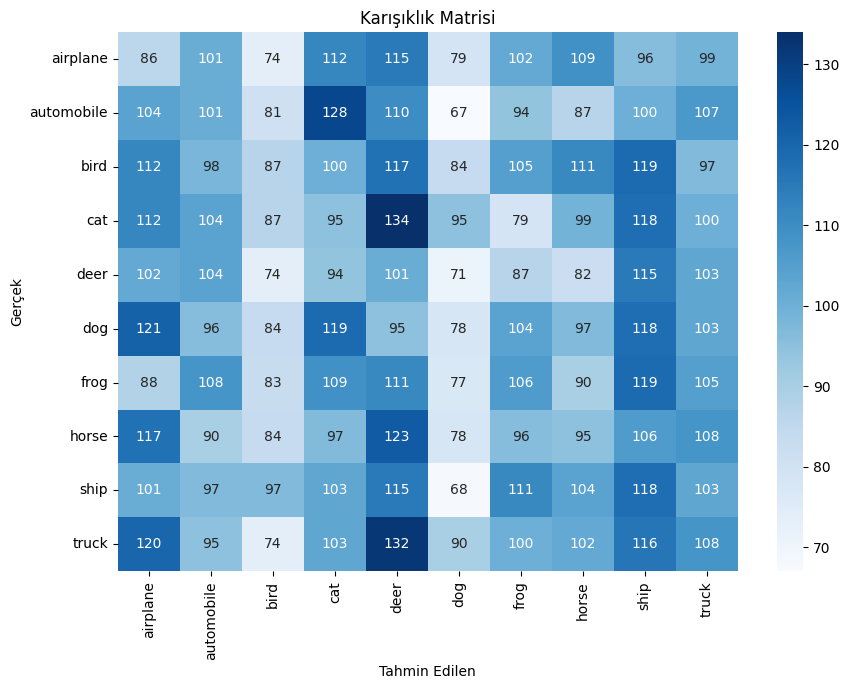

In [ ]:
# CIFAR10 veri seti örneği için sınıf isimleri:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Karışıklık matrisi
cm = confusion_matrix(y_test_split, y_pred2)

# Karışıklık matrisini görselleştirme
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Karışıklık Matrisi")
plt.show()

In [ ]:
# Test verilerinin tahmini (y_pred)
y_pred2 = best_model.predict(x_test_scaled)  # En iyi model ile test verisinde tahmin yap

# Eğer modelin çıktılarını sınıf etiketlerine dönüştürmek gerekiyorsa:
# (Örneğin, bir Keras modelinde softmax çıktısı varsa)
if len(y_pred.shape) > 1:  # Çoklu sınıf ise
    y_pred = np.argmax(y_pred2, axis=1)

# Sınıflandırma raporunu oluştur
report = classification_report(y_test, y_pred2, target_names=None)  # İsterseniz sınıf isimleri ekleyebilirsiniz

# Raporu yazdır
print("Sınıflandırma Raporu:")
print(report)

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.55      0.59      0.57      1000
           1       0.60      0.59      0.59      1000
           2       0.42      0.35      0.38      1000
           3       0.33      0.35      0.34      1000
           4       0.39      0.45      0.42      1000
           5       0.41      0.32      0.36      1000
           6       0.55      0.54      0.54      1000
           7       0.55      0.53      0.54      1000
           8       0.60      0.67      0.63      1000
           9       0.53      0.55      0.54      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



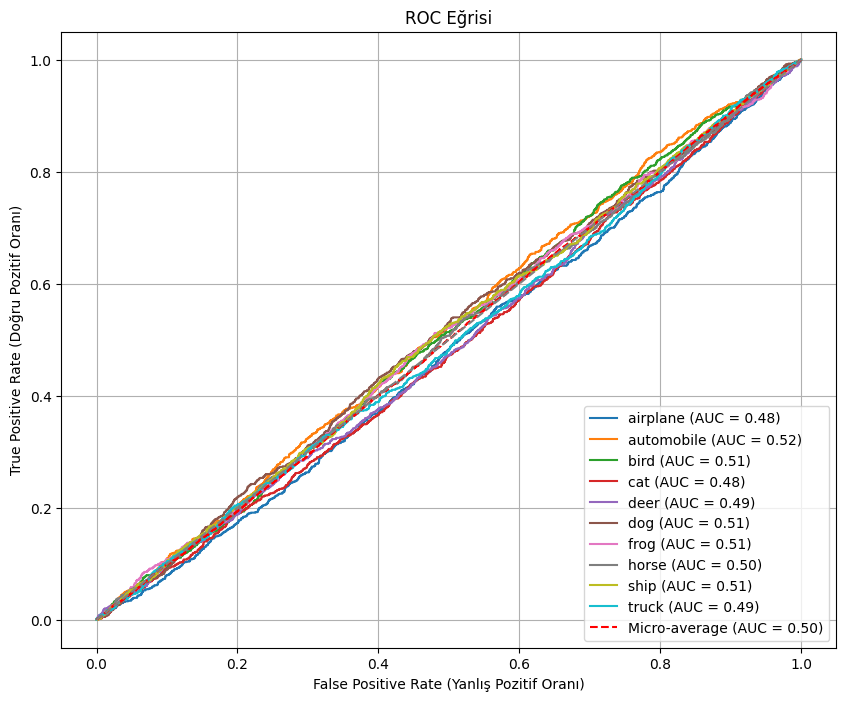

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
# Sınıfları binarize etme (çok sınıflı problem için)
y_test_binarized = label_binarize(y_test_split, classes=range(len(class_names)))
y_pred_proba = best_model.predict_proba(x_test_scaled)

# ROC eğrisi için figür
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    # Her bir sınıf için FPR, TPR ve eşikler
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)  # AUC hesaplama
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

# Mikro ve makro ortalama ROC eğrileri
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle="--", color="red", label=f"Micro-average (AUC = {roc_auc_micro:.2f})")

# Grafiği süsleme
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Rastgele sınıflandırma çizgisi
plt.title("ROC Eğrisi")
plt.xlabel("False Positive Rate (Yanlış Pozitif Oranı)")
plt.ylabel("True Positive Rate (Doğru Pozitif Oranı)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rbf_layer_1 (RBFLayer)               │ (None, 100)                 │         307,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │          51,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 364,042 (1.39 MB)

 Trainable params: 364,042 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/250
782/782 ━━━━━━━━━━━━━━━━━━━━ 67s 84ms/step - accuracy: 0.0989 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 2/250
782/782 ━━━━━━━━━━━━━━━━━━━━ 63s 81ms/step - accuracy: 0.0985 - loss: 2.3029 - val_accuracy: 0.1001 - val_loss: 2.3026
Epoch 3/250
782/782 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step - accuracy: 0.0999 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 4/250
782/782 ━━━━━━━━━━━━━━━━━━━━ 64s 82ms/step - accuracy: 0.1004 - loss: 2.3027 - val_accuracy: 0.0998 - val_loss: 2.3026
Epoch 5/250
782/782 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step - accuracy: 0.0976 - loss: 2.3027 - val_accuracy: 0.0998 - val_loss: 2.3026
Epoch 6/250
782/782 ━━━━━━━━━━━━━━━━━━━━ 64s 81ms/step - accuracy: 0.0953 - loss: 2.3028 - val_accuracy: 0.1002 - val_loss: 2.3024
Epoch 7/250
782/782 ━━━━━━━━━━━━━━━━━━━━ 67s 86ms/step - accuracy: 0.0984 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 8/250
782/782 ━━━━━━━━━━━━━━━━━━━━ 66s 84ms/step - accuracy: 0.0995 - loss: 2

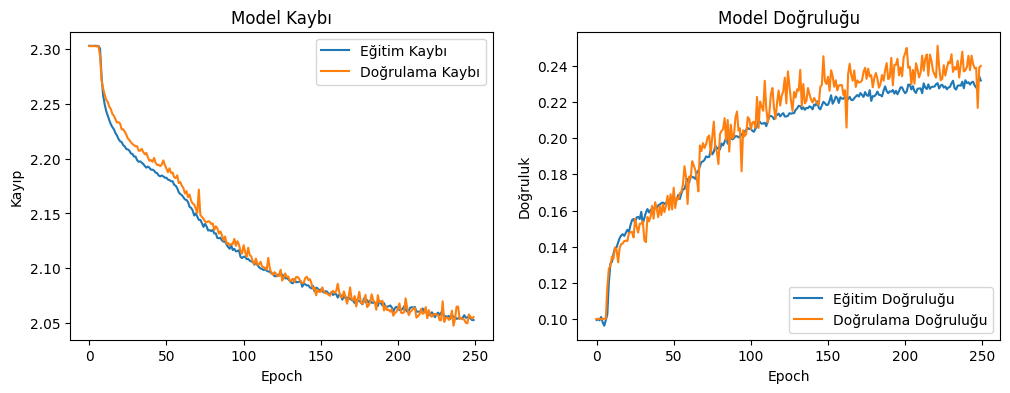

Model başarıyla kaydedildi: rbf_model_improved.h5


In [7]:
# CIFAR-10 verisini yükleme
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Veriyi normalize etme (0-255 aralığından 0-1 aralığına)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Etiketleri one-hot encode etme
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Veri artırma işlemleri
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_train)

# RBF Katmanını tanımlama
class RBFLayer(layers.Layer):
    def __init__(self, n_centroids, gamma=0.1, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.n_centroids = n_centroids
        self.gamma = gamma

    def build(self, input_shape):
        # RBF katmanında merkezler (centroids) için rastgele bir başlangıç
        self.centroids = self.add_weight(
            name='centroids',
            shape=(self.n_centroids, input_shape[1]),  # input_shape[1] tek boyutlu giriş
            initializer="random_normal",
            trainable=True
        )

    def call(self, inputs):
        # Giriş verisini tek boyutlu hale getiriyoruz (flatten)
        inputs_flat = tf.reshape(inputs, [-1, inputs.shape[1]])

        # Her bir giriş için RBF çekirdeği fonksiyonu
        diff = tf.expand_dims(inputs_flat, 1) - self.centroids
        rbf = tf.exp(-self.gamma * tf.reduce_sum(tf.square(diff), axis=-1))
        return rbf

# Modeli oluşturma
def create_rbf_model(input_shape, n_centroids=100, gamma=0.1):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))  # Giriş katmanı
    model.add(layers.Flatten())  # Veriyi tek boyutlu hale getiriyoruz
    model.add(RBFLayer(n_centroids=n_centroids, gamma=gamma))  # RBF katmanı
    model.add(layers.Dense(512, activation='relu'))  # Ekstra dense katmanı
    model.add(layers.Dropout(0.5))  # Overfitting'i engellemek için dropout
    model.add(layers.Dense(10, activation='softmax'))  # Çıkış katmanı: 10 sınıf için softmax
    model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Modeli oluşturuyoruz
input_shape = x_train.shape[1:]  # (32, 32, 3) şeklinde
model = create_rbf_model(input_shape)

# Modelin özetini görüntüleyelim
model.summary()

# Modeli eğitme (veri artırma kullanıyoruz)
history = model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=250, validation_data=(x_test, y_test))

# Modelin doğruluğunu test verisi üzerinde değerlendirme
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Sınıf tahminlerini alıyoruz
y_true = np.argmax(y_test, axis=1)  # Gerçek etiketleri alıyoruz

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Test doğruluğu: {accuracy * 100:.2f}%")

# Eğitim sürecinin görselleştirilmesi (kayıp ve doğruluk grafikleri)
plt.figure(figsize=(12, 4))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.show()

# Modeli kaydetme
model_save_path = 'rbf_model_improved.h5'
model.save(model_save_path)
print(f"Model başarıyla kaydedildi: {model_save_path}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


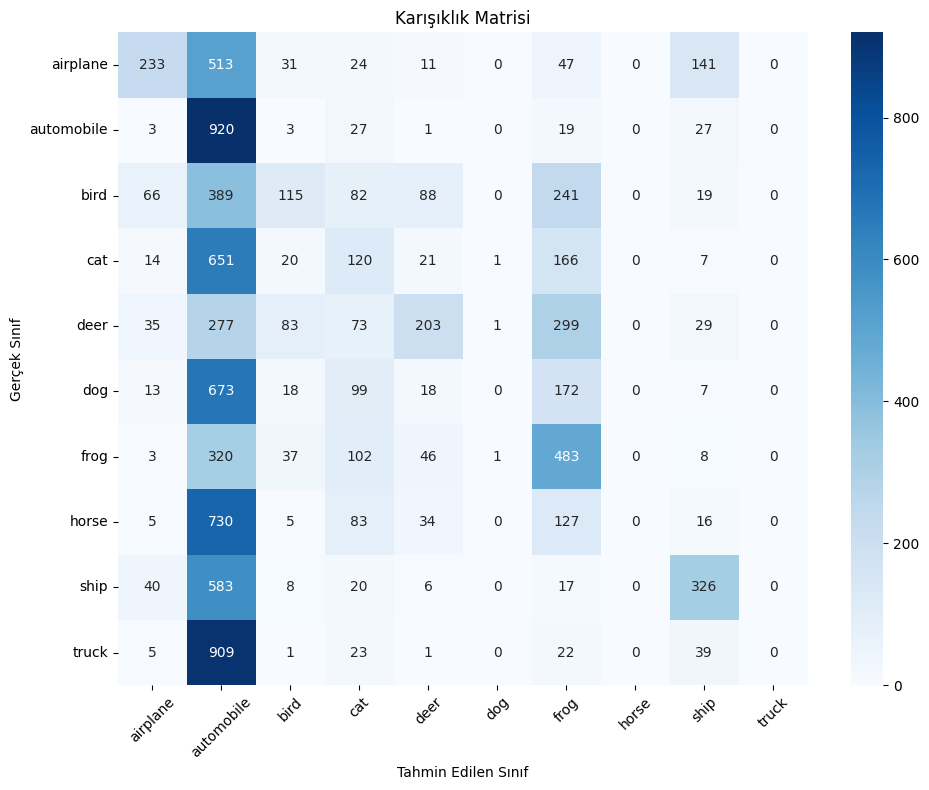

In [13]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Kaydedilen modeli yükleme
model_save_path = 'rbf_model_improved.h5'  # Modelin kaydedildiği dosya
model = load_model(model_save_path, custom_objects={'RBFLayer': RBFLayer})

# Test verisi üzerinde tahmin yapma
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Tahmin edilen sınıflar
y_true = np.argmax(y_test, axis=1)  # Gerçek sınıflar

# Karışıklık matrisi oluşturma
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Karışıklık matrisini görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Karışıklık Matrisi')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.xticks(rotation=45)  # Sınıf isimlerini döndürme
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Modelin dosya yolundan yüklenmesi
model_path = "rbf_model_improved.h5"  # Model dosyasının yolu
model = tf.keras.models.load_model(model_path, custom_objects={'RBFLayer': RBFLayer})  # Modeli yükleme

# Test verisi üzerinde tahmin yapma
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Tahmin edilen sınıflar
y_true = np.argmax(y_test, axis=1)  # Gerçek sınıflar

# Accuracy, Precision, Recall ve F1-Score hesaplama
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')  # Weighted: Sınıf dengesizliklerini hesaba katar
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Sonuçları ekrana yazdırma
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Her sınıf için detaylı rapor
print("\nDetaylı Sınıf Raporu:")
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Accuracy: 0.2400
Precision: 0.2558
Recall: 0.2400
F1-Score: 0.1972

Detaylı Sınıf Raporu:
              precision    recall  f1-score   support

    airplane       0.56      0.23      0.33      1000
  automobile       0.15      0.92      0.26      1000
        bird       0.36      0.12      0.17      1000
         cat       0.18      0.12      0.15      1000
        deer       0.47      0.20      0.28      1000
         dog       0.00      0.00      0.00      1000
        frog       0.30      0.48      0.37      1000
       horse       0.00      0.00      0.00      1000
        ship       0.53      0.33      0.40      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.24     10000
   macro avg       0.26      0.24      0.20     10000
weighted avg       0.26      0.24      0.20     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m